In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn
import torch.optim
np.set_printoptions(threshold=1e3, suppress=True, precision=2, linewidth=80)

In [158]:
class Dataset:
    def __init__(self):
        self.X = None
        self.X_t = None
        self.y_hat = None
        self.df = None
        self.w = None
    def normalize(self):
        mean_x = np.nanmean(self.X, axis=1)
        std_x = np.nanstd(self.X, axis=1)
        std_x[std_x == 0] = 1
        self.X = (self.X - mean_x[:, np.newaxis]) / std_x[:, np.newaxis]
        self.X_t = self.X.T

trainset = Dataset()
trainset.df = pd.read_csv('train_datas_0.csv', dtype='float', na_values='-')
trainset.df1 = pd.read_csv('train_datas_1.csv').apply(pd.to_numeric, errors='coerce')

testset = Dataset()
testset.df = pd.read_csv('test_datas.csv', dtype='float', na_values='-')

In [215]:
def preprocess_training_data(sel_cols=['PM2.5']):
    # correct dataframe
    trainset.df1.drop(trainset.df1.index[-2+2162:-2+2208], inplace=True)
    trainset.df1.dropna(how='all', inplace=True)
    trainset.df1.drop(trainset.df1.index[(trainset.df1 == 0).all(axis=1)], inplace=True)
    for s in (trainset.df, trainset.df1, testset.df):
        for cnam in s.columns:
            # fill NaN with mean
            s[cnam].fillna(s[cnam].mean(), inplace=True)

            # replace outlier with mean
            # TODO: inplace?
            s[cnam][abs(s[cnam] - s[cnam].mean()) > 10 * s[cnam].std()] = s[cnam].mean()

        s.reindex()

    # extract feature
    c = len(sel_cols)
    d = c * 9 * 2 + 18
    n = len(trainset.df) - 9 + len(trainset.df1) - 9
    X = torch.zeros((n, d))
    y_hat = torch.zeros((n, 1))
    
    for i in range(len(trainset.df)-9):
        X[i, 0:c*9] = torch.tensor(trainset.df.iloc[i:i+9][sel_cols].values.flatten())
        X[i, c*9:c*9*2] = X[i, 0:c*9] ** 2
        for j in range(9):
            X[i, c*9*2+j] = (i+j) % 24 # hour
        for j in range(9):
            X[i, c*9*2+9+j] = ((i+j) // 24) % 365 # day
        y_hat[i] = trainset.df.iloc[i+9]['PM2.5']
    
#     off = len(trainset.df) - 9
#     for i in range(len(trainset.df1)-9):
#         X[i+off, 0:15*9] = torch.tensor(trainset.df1.iloc[i:i+9].values.flatten())
#         X[i+off, 15*9] = i % 24 # hour
#         X[i+off, 15*9+1] = (i // 24) % 365 # day
#         y_hat[i] = trainset.df1.iloc[i+9]['PM2.5']

    trainset.X = X
    trainset.y_hat = y_hat
    #trainset.normalize()

preprocess_training_data()#trainset.df.columns)

(array([ 764., 1930., 1824., 1486.,  926.,  706.,  443.,  328.,  147.,
         104.,   48.,   14.,   15.,    9.,    8.,    3.,    4.,    0.,
           0.,    3.]),
 array([  2.  ,   9.55,  17.1 ,  24.65,  32.2 ,  39.75,  47.3 ,  54.85,
         62.4 ,  69.95,  77.5 ,  85.05,  92.6 , 100.15, 107.7 , 115.25,
        122.8 , 130.35, 137.9 , 145.45, 153.  ]),
 <BarContainer object of 20 artists>)

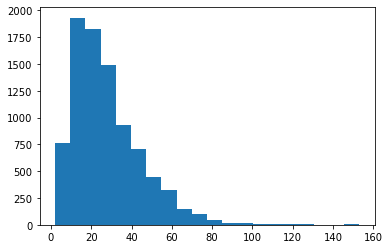

In [175]:
plt.hist(trainset.df['PM2.5'],bins=20)

In [205]:
def train(X, y_hat):
    n, d = X.shape

    linear_module = torch.nn.Linear(d, 1, bias=True)
    loss_func = torch.nn.MSELoss()
    optim = torch.optim.Adam(linear_module.parameters(), lr=1e-3, betas=(0.99, 0.999))
    num_iter = 10000

    print('iter,\tloss,\tw')

    for i in range(num_iter):
        y = linear_module(X)
        loss = loss_func(y, y_hat) + 1e-5 * torch.norm(linear_module.weight)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if i % 1000 == 0:
            print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(d).detach().numpy()))

    true_w, residuals, rank, s  = np.linalg.lstsq(X.view((n, d)).numpy(), y_hat.view(n).numpy())
            
    print('\ntrue w\t\t', true_w)
    print('estimated w\t', linear_module.weight.view(d).detach().numpy())
    print('bias\t', linear_module.bias.view(1).detach().numpy())
    
    testset.linear_module = linear_module

#train(trainset.X, trainset.y_hat)

In [216]:
def preprocess_testing_data(sel_cols=['PM2.5']):
    c = len(sel_cols)
    d = c * 9 * 2 + 18
    n = (len(testset.df) + 8) // 9
    X = torch.zeros((n, d))

    # extract feature
    for i in range(n):
        X[i, 0:c*9] = torch.tensor(testset.df.iloc[i*9:(i+1)*9][sel_cols].values.flatten())
        X[i, c*9:c*9*2] = X[i, 0:c*9] ** 2
        for j in range(9):
            X[i, c*9*2+j] = (i*9+j) % 24 # hour
        for j in range(9):
            X[i, c*9*2+9+j] = ((i*9+j) // 24) % 365 # day
    testset.X = X

    #testset.normalize()

preprocess_testing_data()#testset.df.columns)

In [202]:
def test():
    X = testset.X
    linear_module = testset.linear_module
    n, d = X.shape
    
    y = linear_module(X)
    y = torch.round(y).view(n).detach().numpy()
    print(y)
    testset.y = y

test()

[ 19.  20.  22.  36.  28.  21.  49.  66.  69.  58.  47.  46.  62.  49.  42.
  47.  35.  25.  28.  35.  39.  37.  31.  24.  28.  18.   9.  12.  22.  26.
  28.  21.  22.  19.  27.  28.  30.  22.  11.   9.  16.  28.  25.  28.  23.
  30.  39.  35.  36.  34.  48.  35.  38.  42.  24.  25.  19.  15.   9.   5.
   6.   1.  10.  10.  13.   9.   8.  11.  24.  27.  28.  33.  27.  25.  56.
  27.  25.  20.  19.  18.  21.  16.   8.  14.  21.  19.  15.   9.  11.  10.
  17.  15.  17.  24.  27.  34.  41.  40.  34.  23.  54.  37.  27.  14.  -1.
  30.  30.  24.  17.   7.   5.  15.  21.  16.  18.  22.  26.  28.  27.  26.
  24.  28.  30.  30.  26.  31.  26.  27.  44.  50.  41.  15.  14.  11.  25.
  18.  20.  23.  30.  22.  32.  31.  27.  12.  15.  18.  22.  28.  29.  12.
   5.  11.  13.  24.  28.  29.  12.  20.  26.  27.  27.  23.  15.  12.   8.
  20.  29.  36.  38.  33.  41.  18.   3.  16.  17.  25.  27.  22.  38.  30.
  26.  31.  30.  41.  31.  33.  22.  29.  36.  36.  28.  28.  28.  20.  25.
  27.  22.  

In [203]:
pred_df = pd.DataFrame({
    'id': ['id_' + str(i) for i in range(500)],
    'value': testset.y
})
pred_df.to_csv('submission.csv', index=False)

(array([ 13., 135., 114.,  96.,  83.,  36.,  12.,   6.,   3.,   2.]),
 array([-5. ,  2.7, 10.4, 18.1, 25.8, 33.5, 41.2, 48.9, 56.6, 64.3, 72. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

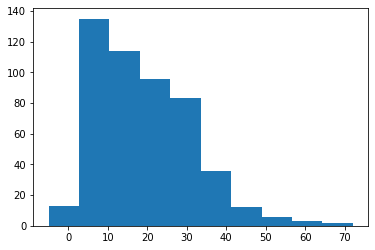

In [139]:
plt.hist(testset.y)

In [ ]:
def validate():
    X = trainset.X
    y_hat = trainset.y_hat
    n, d = X.shape

    validate_sz = 2000
    losses = []
    loss_func = torch.nn.MSELoss()
    for i in range(0, n, validate_sz):
        idx_validate = pd.Series([False] * n)
        idx_validate[i:i+validate_sz] = True

        train(X[~idx_validate], y_hat[~idx_validate])
        y = testset.linear_module(X[idx_validate])
        l = loss_func(y, y_hat[idx_validate])
        losses.append(l.item())
        
        break

    print('validate loss', np.mean(losses))
    print()

validate()

iter,	loss,	w
0,	24952.33,	[ 0.14 -0.01 -0.11 -0.07 -0.1   0.13  0.04  0.05  0.03 -0.05  0.1   0.12 -0.15
  0.02  0.13 -0.02  0.02  0.04  0.08  0.11 -0.17  0.12 -0.11 -0.16  0.05  0.08
 -0.06 -0.1   0.06  0.11  0.02  0.1  -0.16 -0.14  0.14 -0.07]


In [ ]:
def closed_form_solution():
    w_hat, residuals, rank, s  = np.linalg.lstsq(trainset.X_t, trainset.y_hat)
    X = trainset.X
    X_t = trainset.X_t
    y_hat = trainset.y_hat
    assert w_hat.shape[0] == DIM
    print('w_hat',w_hat)
    print('train loss', np.linalg.norm(trainset.X_t.dot(w_hat) - trainset.y_hat)**2)
    testset.w = w_hat

    loss = []
    d, n = trainset.X.shape
    validate_sz = 2000
    for i in range(0, n, validate_sz):
        idx_validate = pd.Series([False] * n)
        idx_validate[i:i+validate_sz] = True
        loss.append(validate(X[:, idx_validate], y_hat[idx_validate], testset.w))
    print('validation loss', np.mean(loss))
    
    return np.dot(testset.X_t, w_hat).round(0).astype(int)

# y_pred = closed_form_solution()